Инициализация модели...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


Визуализация примера обработки кадра...


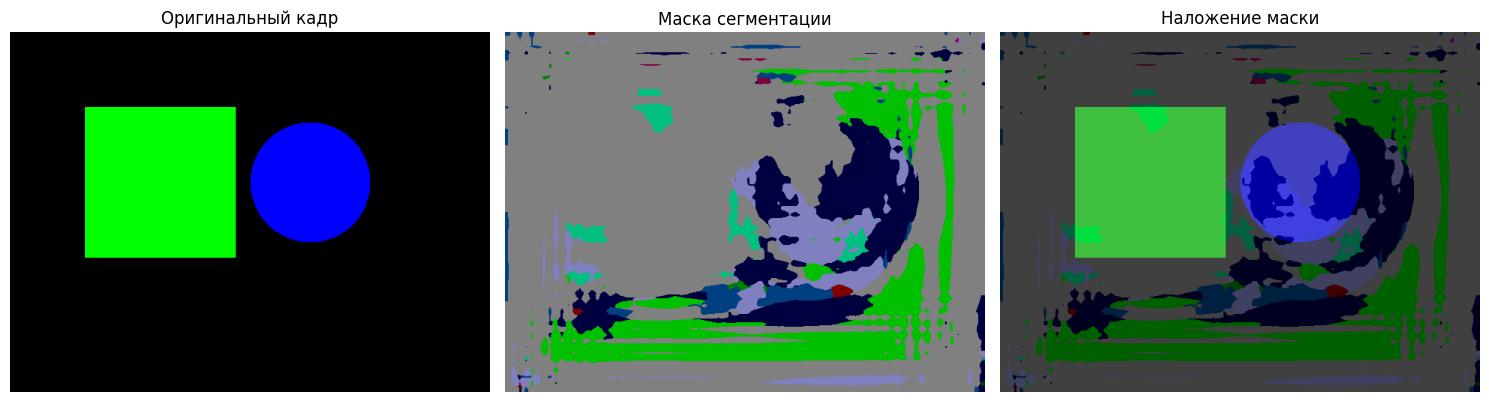


Начало обработки видео: /content/1112645_Approach_Winter-clothes_3840x2160 (online-video-cutter.com).mp4


Обработка видео:  99%|█████████▊| 67/68 [03:09<00:02,  2.83s/it]


Обработано кадров: 67/68
Видео сохранено как: output_video_segmented.mp4

Готово!


In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models.segmentation import fcn_resnet50
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Настройки
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 21  # Для VOC
VIDEO_PATH = '/content/1112645_Approach_Winter-clothes_3840x2160 (online-video-cutter.com).mp4'  # Замените на свой путь
OUTPUT_PATH = 'output_video_segmented.mp4'

# Цвета для классов VOC (20 классов + фон + ignore)
VOC_COLORS = np.array([
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
    [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
    [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
    [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
    [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
    [0, 64, 128],  # 20 классов + фон
    [255, 255, 255]  # ignore_index=255
], dtype=np.uint8)

# Трансформации для изображений
def get_transform():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# Инициализация модели (без загрузки весов)
def initialize_model():
    model = fcn_resnet50(weights=None, num_classes=NUM_CLASSES)
    model = model.to(DEVICE)
    model.eval()
    return model

# Обработка одного кадра
def process_frame(frame, model, transform):
    if frame is None:
        return None, None

    # Конвертируем в PIL Image
    pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Применяем трансформации
    img_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)

    # Предсказание
    with torch.no_grad():
        output = model(img_tensor)['out']
        pred_mask = output.argmax(1).squeeze().cpu().numpy()

    # Создаем цветную маску
    pred_mask_vis = np.where(pred_mask == 255, NUM_CLASSES, pred_mask)
    colored_mask = VOC_COLORS[pred_mask_vis]

    # Наложение маски на оригинальное изображение (50% прозрачности)
    overlay = cv2.addWeighted(frame, 0.5, colored_mask, 0.5, 0)

    return overlay, colored_mask

# Основная функция обработки видео
def process_video(input_path, output_path, model):
    # Открываем видео
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"Ошибка открытия видео файла: {input_path}")
        return

    # Получаем параметры видео
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Создаем VideoWriter для сохранения результата
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Прогресс-бар
    pbar = tqdm(total=total_frames, desc="Обработка видео")

    transform = get_transform()
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Обработка кадра
        overlay, _ = process_frame(frame, model, transform)

        if overlay is not None:
            # Сохранение кадра
            out.write(overlay)
            frame_count += 1

        pbar.update(1)

    # Освобождаем ресурсы
    cap.release()
    out.release()
    pbar.close()
    print(f"\nОбработано кадров: {frame_count}/{total_frames}")
    print(f"Видео сохранено как: {output_path}")

# Визуализация примера кадра
def visualize_example_frame(model):
    # Создаем тестовый кадр
    test_frame = np.zeros((480, 640, 3), dtype=np.uint8)
    cv2.rectangle(test_frame, (100, 100), (300, 300), (0, 255, 0), -1)
    cv2.circle(test_frame, (400, 200), 80, (255, 0, 0), -1)

    transform = get_transform()
    overlay, colored_mask = process_frame(test_frame, model, transform)

    if overlay is None or colored_mask is None:
        print("Ошибка при обработке тестового кадра")
        return

    # Отображаем результаты
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB))
    plt.title("Оригинальный кадр")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(colored_mask, cv2.COLOR_BGR2RGB))
    plt.title("Маска сегментации")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Наложение маски")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Инициализация модели
    print("Инициализация модели...")
    try:
        model = initialize_model()
    except Exception as e:
        print(f"Ошибка инициализации модели: {e}")
        exit()

    # Визуализация примера кадра
    print("Визуализация примера обработки кадра...")
    visualize_example_frame(model)

    # Обработка видео
    print(f"\nНачало обработки видео: {VIDEO_PATH}")
    process_video(VIDEO_PATH, OUTPUT_PATH, model)

    print("\nГотово!")